In [1]:
root_folder = '/media/DATA/jbonato/astro_segm'

In [2]:
import numpy as np
import numpy.ma as ma
import os
import h5py
from skimage import io
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import math
import time
import sys
import pickle
from visdom import Visdom

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from collections import defaultdict
from sklearn.metrics import f1_score
import cv2
import pandas as pd
import h5py

############### Visualization

from ipywidgets import Button, Layout
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display,clear_output,Video,Image
from copy import copy
import numpy.ma as ma
import matplotlib.colors as colors
import imageio


sys.path.insert(0,root_folder+'/RASTA/modules/')
from gen_single_astro  import filt_im
from sel_active_reg_gen import *
from model.dense_up import dense_up

from test_fun import gen_sc_mask,fix_mask,prob_calc,small_soma_to_proc,common_merge,art_rem_large,art_rem

from get_traces import update_dict_DNN
from gui_results import layout
from mask_roi_from_fiji import create_mask

# model to import
model = dense_up(3)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device1 = torch.device('cpu')#('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


###
MAX_ROI_AREA_PROC=30
MU_PX = 1
DOMAIN_RADIUS = 60
# motion corr in extracting traces
motion_corr=True

<img src="gpu_org.png" width=400 height=600 />

### GPU settings
- List coordinates selects the position of top left corner of patches
- Patches HxW are determined by bb key. The bb should be set as a box that can surround an astrocytes
- BPM_ratio selects teh number of blocks inside a Patch
- num of threads and blocks should be set taking into account GPU specs (ie 15 blocks and 32 threads cover the entire FOV with BPM_ratio=3) and num of threads per block must satisfy H_of_patch = BPM_ratio*threads ie bb=96 BPM_ratio=3 threads = 32

In [3]:
#PARAMS
N=256
M=256

fov_list = [18]
fov_DNN_weights_folder = root_folder+'/weights/dense_up' 
set_dir=root_folder+'/set1/'

In [4]:
vis_flag = False
##### LOAD PARAM DICT
with open(set_dir+'.tmp/dict_dataset1.txt', "rb") as fp:   #Pickling
    dict_param = pickle.load(fp)
max_min = dict_param['max_min']
dict_param['blocks']=6
dict_param['threads']=16
dict_param['BPM_ratio']=6

In [5]:
16*6

96

In [6]:
dict_param


{'list': [0, 40, 80, 120, 160],
 'blocks': 6,
 'threads': 16,
 'BPM_ratio': 6,
 'bb': 96,
 'N_pix_st': 100,
 'astr_min': 80,
 'percentile': 80,
 'pad': 5,
 'astro_num': 4,
 'init_th_': 0.6,
 'decr_dim': 10,
 'decr_th': 25,
 'corr_int': False,
 'gpu_flag': True,
 'max_min': array([345,  89]),
 'th1_p': 0.25,
 'th2_p': 0.1}

In [8]:
dict_im = {}
dict_im['Astro_domain_radius'] = DOMAIN_RADIUS
for jj in fov_list:
    #im_list = []
    Res_1 = np.zeros((N,M,3))

    test_folder_str =str(jj)
    if len(test_folder_str)==1:
        test_folder_str1='00'+test_folder_str
    else:
        test_folder_str1='0'+test_folder_str

    model.load_state_dict(torch.load(fov_DNN_weights_folder+test_folder_str1+'D1.pt'))
    
    #collect stack to analyze
    
    stack_dir = '/media/DATA/jbonato/astro_segm/set1/'+test_folder_str+'/'

    items_stack = os.listdir(stack_dir)

    print(stack_dir + items_stack[0])
    stack = io.imread(stack_dir + items_stack[0]).astype(np.uint16)
    dict_im['t-series_'+test_folder_str1] = stack
    frames,_,_ = stack.shape

    a_reg = sel_active_reg(stack.astype(np.float32),dict_param)
    im_out,cover = a_reg.check_sel_active_reg_gpu_gen(void_out=False)
    
    print('Min and Max of normalization matrix',cover.min(),cover.max())
    print('Min and Max of controll activity map: tehse should be 1: ',(im_out/cover).min(),(im_out/cover).max())

/media/DATA/jbonato/astro_segm/set1/18/TSeries-07262018-1151-1126_Ch2__movie_corrected_aligned.tiff
GPU started with  (6, 6)  blocks and  (16, 16)  threads per block
Iteration per block:  5.0
debug True
Min and Max of normalization matrix 1 9
Min and Max of controll activity map: tehse should be 1:  1.0 1.0


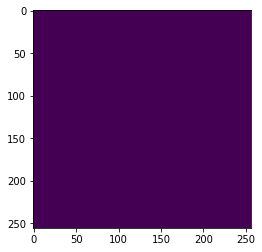

In [11]:
#these should be a grid describing how the FoV is covered
plt.imshow(im_out/cover)